Loading data from /kaggle/input/forest-cover-type-dataset/covtype.csv...
Generating EDA visualizations...


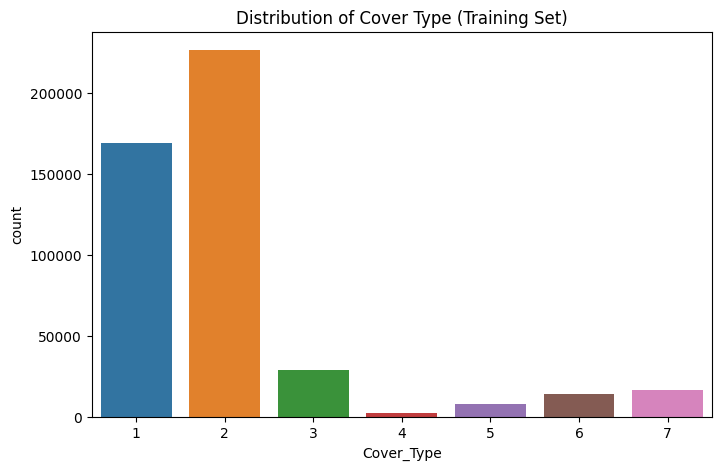

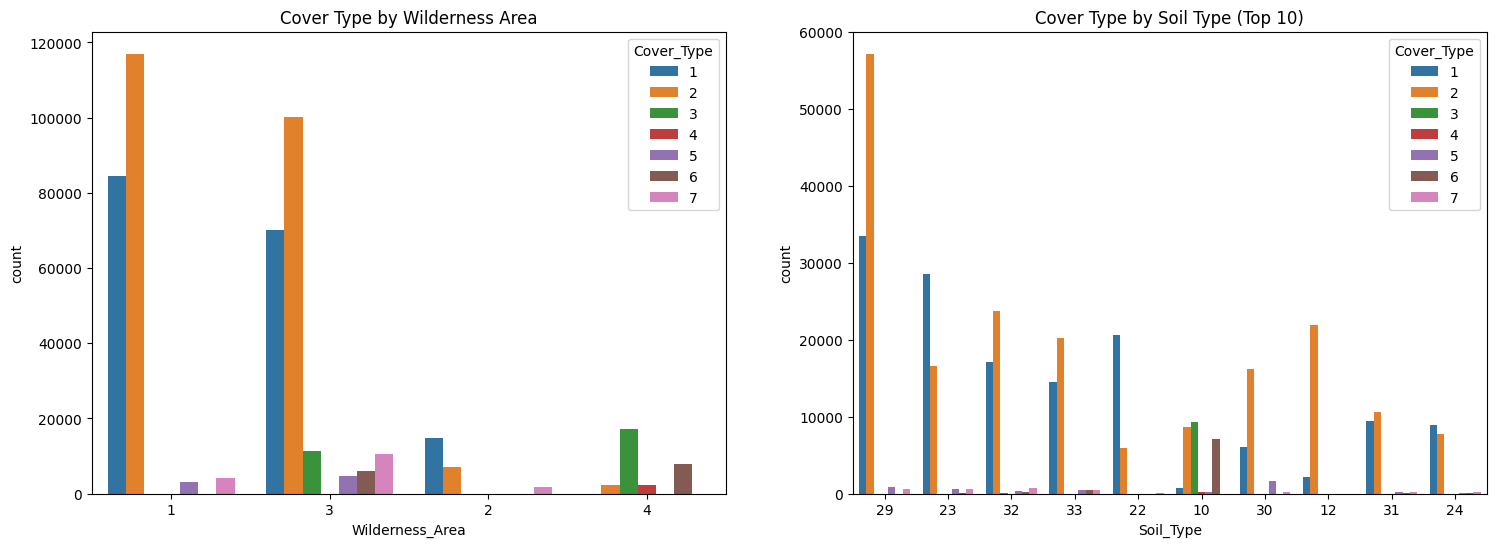

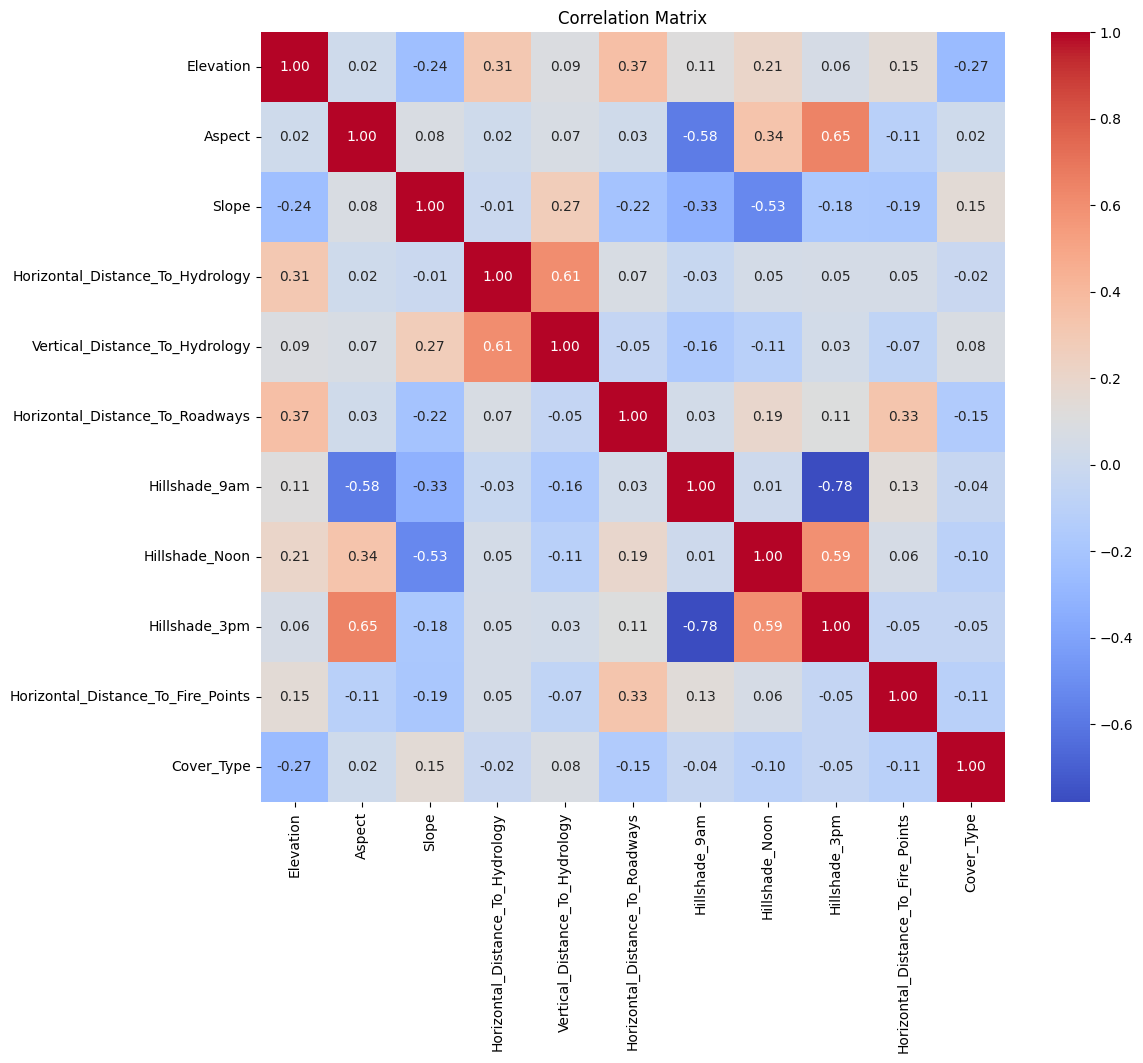

Generating Distance Analysis...


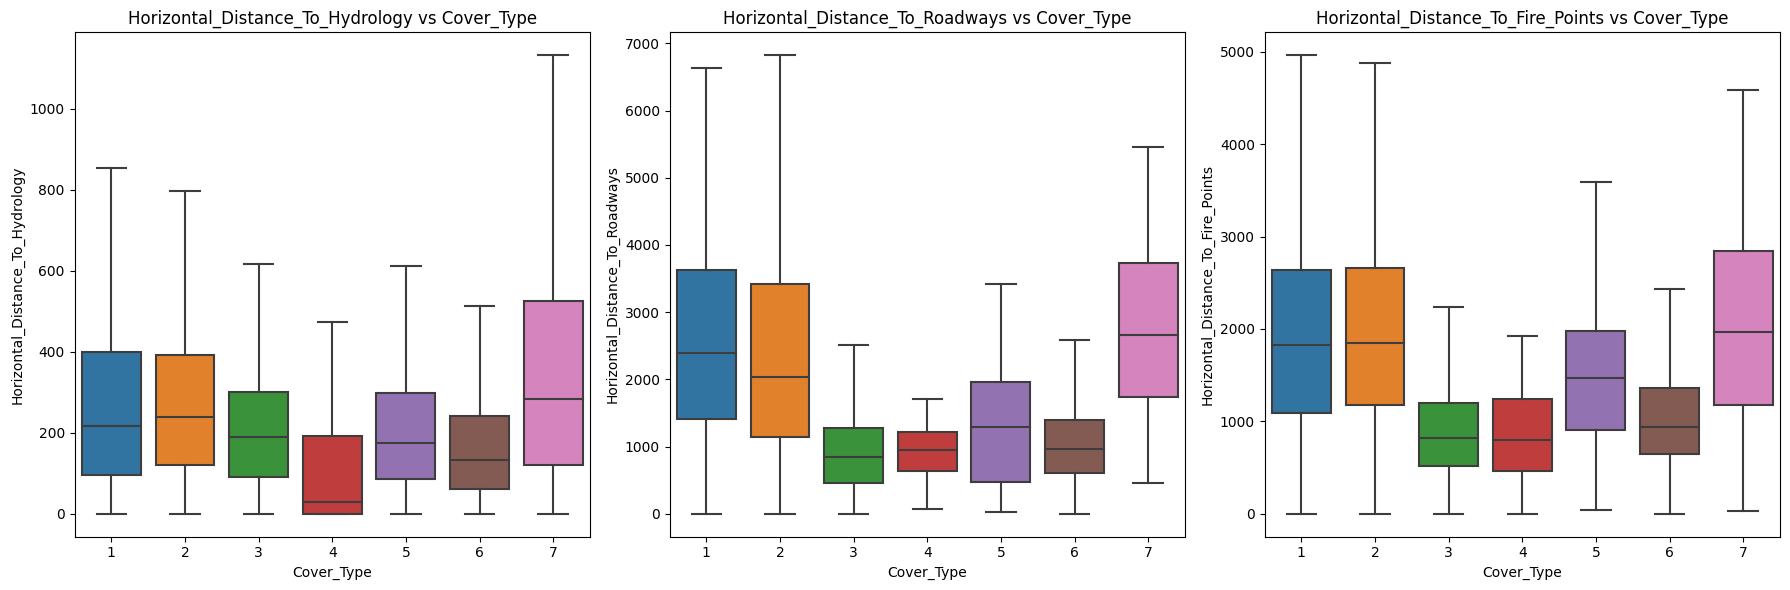

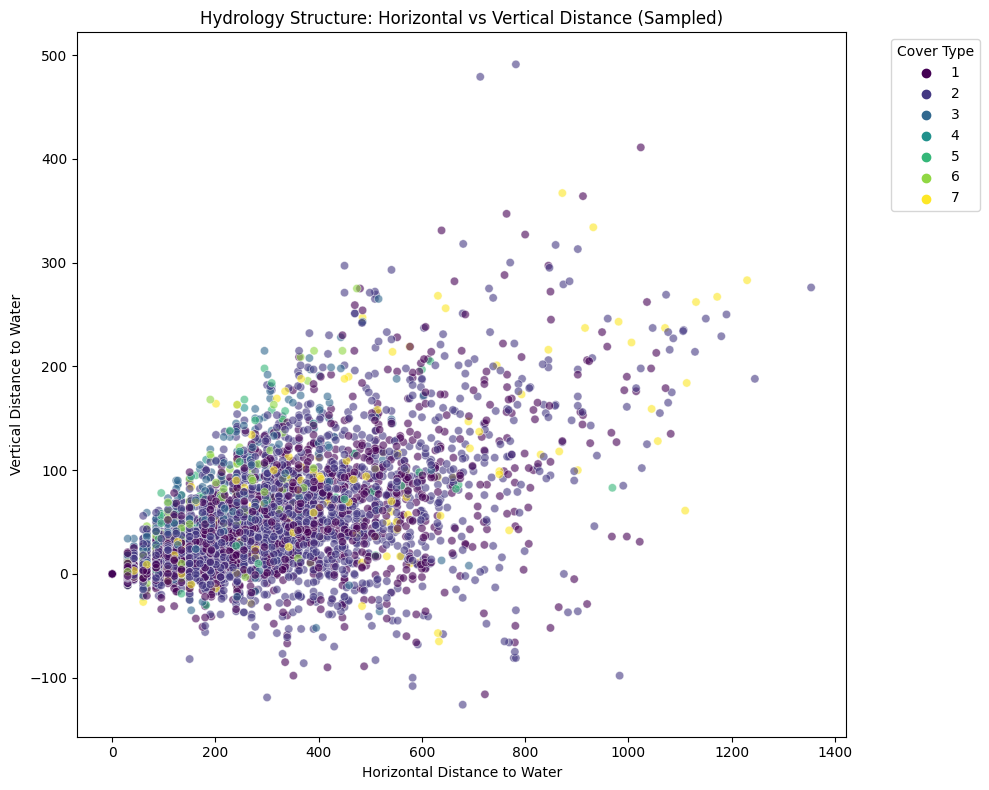

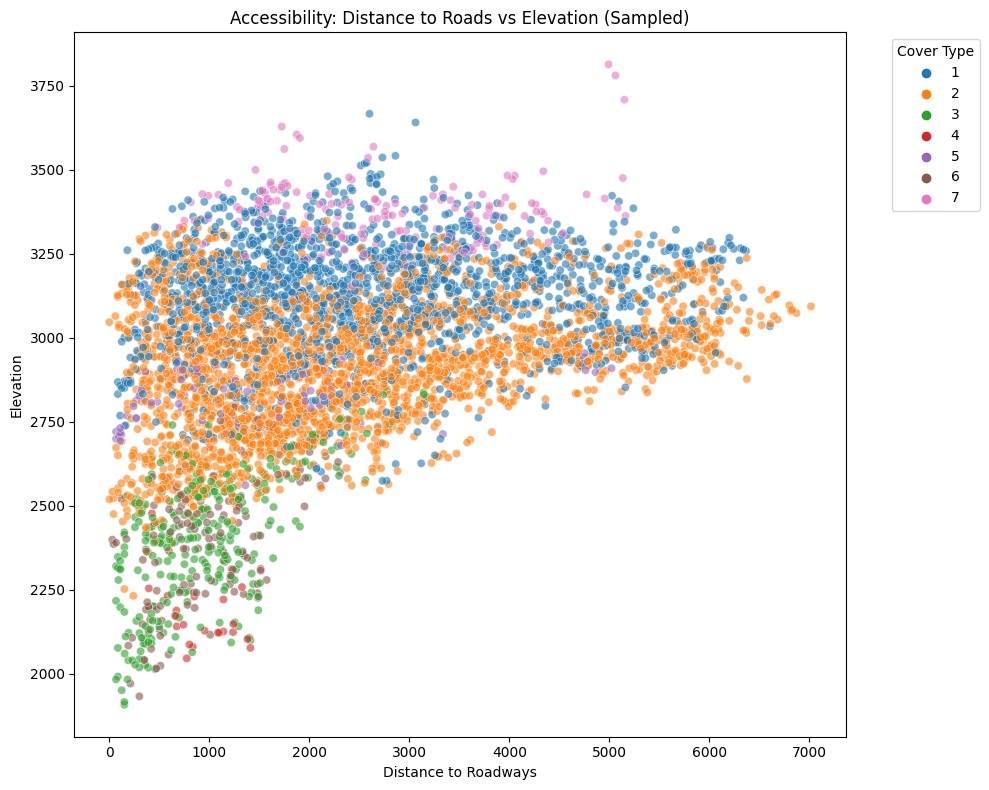

EDA Complete.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 1. Configuration & Data Loading
DATA_PATH = '/kaggle/input/forest-cover-type-dataset/covtype.csv' 
# DATA_PATH = 'forest_dataset.csv' # Uncomment if running locally

print(f"Loading data from {DATA_PATH}...")
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {DATA_PATH}. Please check the path.")
    raise

# 2. Data Splitting (Preventing Leakage)
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. EDA Logic
print("Generating EDA visualizations...")
train_df = X_train.copy()
train_df['Cover_Type'] = y_train

# A. Target Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Cover_Type', data=train_df)
plt.title('Distribution of Cover Type (Training Set)')
plt.show()

# B. Feature Engineering for Visualization
def reverse_one_hot(df, prefix):
    cols = [c for c in df.columns if prefix in c]
    if not cols: return pd.Series(index=df.index, dtype='object')
    return df[cols].idxmax(axis=1).apply(lambda x: x.replace(prefix, ''))

train_df['Wilderness_Area'] = reverse_one_hot(train_df, 'Wilderness_Area')
train_df['Soil_Type'] = reverse_one_hot(train_df, 'Soil_Type')

# C. Categorical Analysis
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.countplot(x='Wilderness_Area', hue='Cover_Type', data=train_df, ax=ax[0])
ax[0].set_title('Cover Type by Wilderness Area')

top_soils = train_df['Soil_Type'].value_counts().index[:10]
sns.countplot(x='Soil_Type', hue='Cover_Type', 
              data=train_df[train_df['Soil_Type'].isin(top_soils)], 
              ax=ax[1], order=top_soils)
ax[1].set_title('Cover Type by Soil Type (Top 10)')
plt.show()

# D. Correlation Matrix
continuous_cols = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                  'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                  'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                  'Horizontal_Distance_To_Fire_Points', 'Cover_Type']
continuous_cols = [c for c in continuous_cols if c in train_df.columns]

plt.figure(figsize=(12, 10))
sns.heatmap(train_df[continuous_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


print("Generating Distance Analysis...")

# 1. Comparative Boxplots for all "Distance" features
distance_cols = ['Horizontal_Distance_To_Hydrology', 
                 'Horizontal_Distance_To_Roadways', 
                 'Horizontal_Distance_To_Fire_Points']

plt.figure(figsize=(18, 6))
for i, col in enumerate(distance_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='Cover_Type', y=col, data=train_df, showfliers=False) # Hiding outliers for clarity
    plt.title(f'{col} vs Cover_Type')
plt.tight_layout()
plt.show()

# 2. Hydrology Structure (Horizontal vs Vertical)
# This reveals if trees grow in steep ravines vs flat riverbanks
plt.figure(figsize=(10, 8))
# We take a sample of 5000 points to keep the scatter plot readable and fast
sample_df = train_df.sample(n=5000, random_state=42)
sns.scatterplot(x='Horizontal_Distance_To_Hydrology', 
                y='Vertical_Distance_To_Hydrology', 
                hue='Cover_Type', palette='viridis', data=sample_df, alpha=0.6)
plt.title('Hydrology Structure: Horizontal vs Vertical Distance (Sampled)')
plt.xlabel('Horizontal Distance to Water')
plt.ylabel('Vertical Distance to Water')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cover Type')
plt.tight_layout()
plt.show()

# 3. Accessibility Analysis: Elevation vs Distance to Roadways
# Checks if certain cover types are only "accessible" at specific heights
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Horizontal_Distance_To_Roadways', 
                y='Elevation', 
                hue='Cover_Type', palette='tab10', data=sample_df, alpha=0.6)
plt.title('Accessibility: Distance to Roads vs Elevation (Sampled)')
plt.xlabel('Distance to Roadways')
plt.ylabel('Elevation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cover Type')
plt.tight_layout()
plt.show()

print("EDA Complete.")

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Initialize a dictionary to store results across blocks

if 'model_performance' not in locals():
    model_performance = {}

# 1. Load & Split
df = pd.read_csv('/kaggle/input/forest-cover-type-dataset/covtype.csv')
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Stratified Split (Fixed Seed = Consistent y_test across blocks)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Preprocessing
continuous_cols = X.columns[:10]
binary_cols = X.columns[10:]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', 'passthrough', binary_cols)
    ]
)

# 3. Model
lr_model = LogisticRegression(
    solver='saga', multi_class='multinomial', class_weight='balanced',
    C=1.0, max_iter=1000, random_state=42, n_jobs=-1
)

lr_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', lr_model)])

# 4. Train & Measure
print("Training Logistic Regression...")
start = time.time()
lr_pipeline.fit(X_train, y_train)
lr_time = time.time() - start

# 5. Store Results
lr_pred = lr_pipeline.predict(X_test)
model_performance['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, lr_pred),
    'F1-Macro': f1_score(y_test, lr_pred, average='macro'),
    'Training Time (s)': lr_time
}
print(f"LR Training Complete. Results stored.")

Training Logistic Regression...
LR Training Complete. Results stored.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [3]:
from sklearn.svm import SVC

# 1. Stratified Subsample (Same y_test as Block 1 due to random_state=42)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create 50k Subsample
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train_full, y_train_full, train_size=50000, random_state=42, stratify=y_train_full
)

# 2. Model (RBF)
svm_model = SVC(
    kernel='rbf', C=10, gamma='scale', class_weight='balanced',
    cache_size=2000, random_state=42
)

svm_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', svm_model)])

# 3. Train & Measure
print("Training SVM (Subsampled)...")
start = time.time()
svm_pipeline.fit(X_train_sub, y_train_sub)
svm_time = time.time() - start

# 4. Store Results
svm_pred = svm_pipeline.predict(X_test)
model_performance['SVM (RBF)'] = {
    'Accuracy': accuracy_score(y_test, svm_pred),
    'F1-Macro': f1_score(y_test, svm_pred, average='macro'),
    'Training Time (s)': svm_time
}
print(f"SVM Training Complete. Results stored.")

Training SVM (Subsampled)...
SVM Training Complete. Results stored.


In [ ]:
import tensorflow as tf
import os
import random
import time
import pandas as pd
import numpy as np
from keras import layers, models, callbacks, optimizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score

# Set Seeds
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds(42)

# 1. Feature Engineering (Reload clean df to be safe)
df_nn = pd.read_csv('/kaggle/input/forest-cover-type-dataset/covtype.csv')
df_nn['Hydro_Euclidean'] = np.sqrt(
    df_nn['Horizontal_Distance_To_Hydrology']**2 +
    df_nn['Vertical_Distance_To_Hydrology']**2
)
df_nn['Hydro_Elevation'] = df_nn['Elevation'] - df_nn['Vertical_Distance_To_Hydrology']

X_nn = df_nn.drop('Cover_Type', axis=1)
y_nn = df_nn['Cover_Type'] - 1 # 0-indexed targets

# Split 
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn, y_nn, test_size=0.2, random_state=42, stratify=y_nn
)

print(f"Training Samples: {X_train_nn.shape[0]}")
print(f"Testing Samples:  {X_test_nn.shape[0]} (Matched to LR/SVM split)")

# Scale
continuous_cols_nn = [c for c in X_nn.columns if not c.startswith(('Soil', 'Wilderness'))]
binary_cols_nn = [c for c in X_nn.columns if c not in continuous_cols_nn]

preprocessor_nn = ColumnTransformer([
    ('num', StandardScaler(), continuous_cols_nn),
    ('cat', 'passthrough', binary_cols_nn)
])

X_train_scaled = preprocessor_nn.fit_transform(X_train_nn)
X_test_scaled = preprocessor_nn.transform(X_test_nn)

# 2. Model Architecture
def build_model(input_dim, num_classes):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(512, activation='swish')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation='swish')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

nn_model = build_model(X_train_scaled.shape[1], 7)

# 3. Train
print("Training Neural Network...")
start = time.time()
history = nn_model.fit(
    X_train_scaled, y_train_nn,
    validation_split=0.1, epochs=100, batch_size=512, verbose=0,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5)
    ]
)
nn_time = time.time() - start

# 4. Store Results
nn_pred_prob = nn_model.predict(X_test_scaled)
nn_pred = np.argmax(nn_pred_prob, axis=1)

# Ensure dictionary exists
if 'model_performance' not in locals():
    model_performance = {}

model_performance['Neural Network'] = {
    'Accuracy': accuracy_score(y_test_nn, nn_pred),
    'F1-Macro': f1_score(y_test_nn, nn_pred, average='macro'),
    'Training Time (s)': nn_time
}
print(f"NN Training Complete. Results stored.")

2025-12-12 14:36:00.754897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765550160.773014    2632 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765550160.778316    2632 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Training Samples: 464809
Testing Samples:  116203 (Matched to LR/SVM split)


I0000 00:00:1765550167.856714    2632 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765550167.857304    2632 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Training Neural Network...


I0000 00:00:1765550171.516166    2685 service.cc:148] XLA service 0x4fc3d3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765550171.516200    2685 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765550171.516204    2685 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765550171.845448    2685 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765550174.549456    2685 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3632/3632 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
NN Training Complete. Results stored.


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

print("==========================================")
print("     FINAL CLASSIFICATION REPORTS         ")
print("==========================================")

# 1. Logistic Regression (Uses y_test from 80/20 split)
if 'lr_pipeline' in locals():
    print("\n--- Logistic Regression (Test Set: 20%) ---")
    y_pred_lr = lr_pipeline.predict(X_test) 
    print(classification_report(y_test, y_pred_lr))

# 2. SVM (Uses y_test from 80/20 split)
if 'svm_pipeline' in locals():
    print("\n--- SVM (Test Set: 20%) ---")
    y_pred_svm = svm_pipeline.predict(X_test)
    print(classification_report(y_test, y_pred_svm))

# 3. Neural Network (Uses y_test_nn which is now 20% split)
if 'nn_model' in locals():
    print("\n--- Neural Network (Test Set: 20%) ---")
    
    # Step A: Get probabilities
    y_pred_prob_nn = nn_model.predict(X_test_scaled, verbose=0)
    
    # Step B: Convert to 0-6 class indices
    y_pred_nn_0_index = np.argmax(y_pred_prob_nn, axis=1)
    
    # Step C: Map BACK to 1-7 to match the original class names
    y_pred_nn_final = y_pred_nn_0_index + 1
    
    # Step D: Map the Truth (y_test_nn) back to 1-7 as well
    y_true_nn_final = y_test_nn + 1
    
    # Generate Report
    print(classification_report(y_true_nn_final, y_pred_nn_final))

print("==========================================")

     FINAL CLASSIFICATION REPORTS         

--- Logistic Regression (Test Set: 20%) ---
              precision    recall  f1-score   support

           1       0.68      0.66      0.67     42368
           2       0.79      0.52      0.63     56661
           3       0.70      0.63      0.66      7151
           4       0.35      0.83      0.49       549
           5       0.10      0.78      0.18      1899
           6       0.33      0.64      0.44      3473
           7       0.41      0.89      0.56      4102

    accuracy                           0.60    116203
   macro avg       0.48      0.71      0.52    116203
weighted avg       0.70      0.60      0.63    116203


--- SVM (Test Set: 20%) ---
              precision    recall  f1-score   support

           1       0.80      0.79      0.80     42368
           2       0.86      0.75      0.80     56661
           3       0.80      0.81      0.80      7151
           4       0.64      0.82      0.72       549
           5   


=== FINAL PERFORMANCE TABLE ===
                 Model  Accuracy  F1-Macro  Training Time (s)
0  Logistic Regression    0.6024    0.5191          1301.2848
1            SVM (RBF)    0.7805    0.7137           131.6573
2       Neural Network    0.9559    0.9299           265.3389


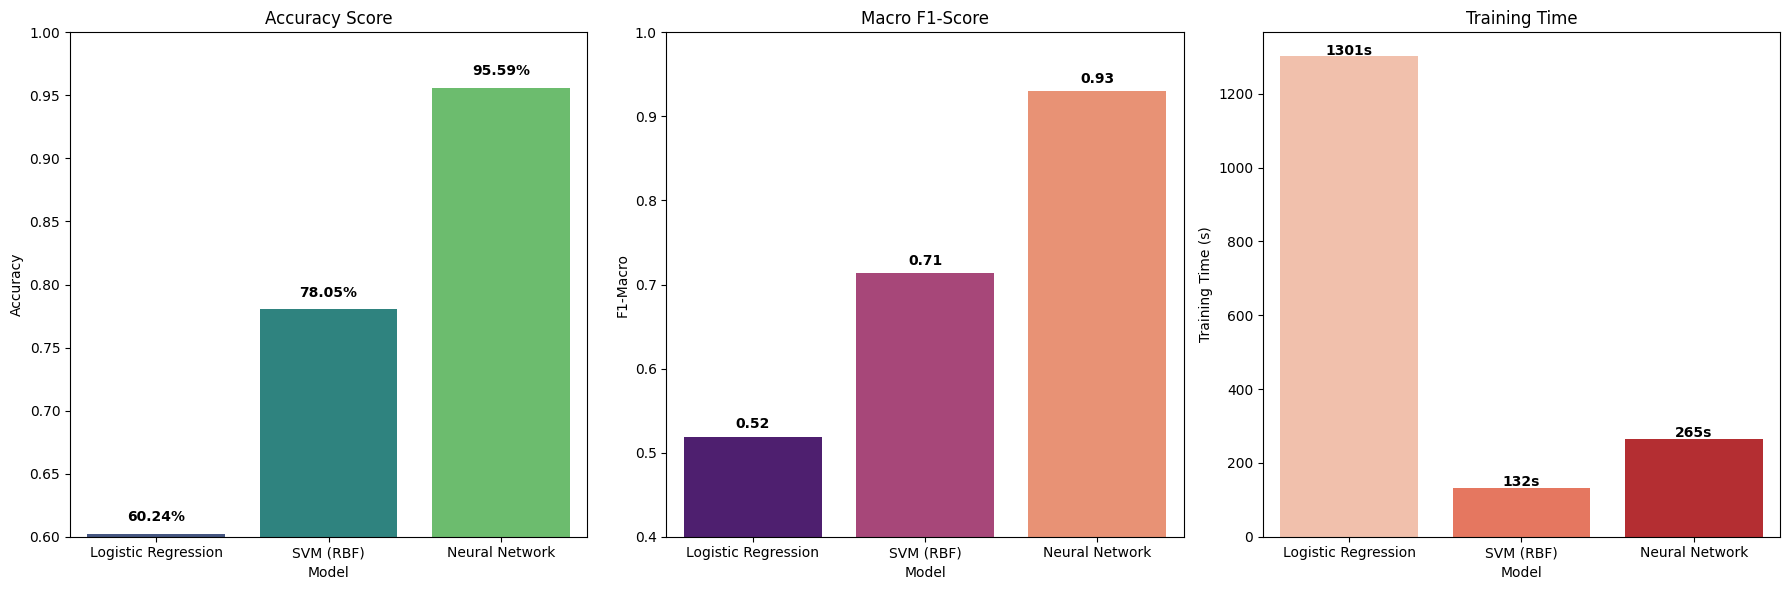

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Convert Dictionary to DataFrame
results_df = pd.DataFrame(model_performance).T.reset_index()
results_df = results_df.rename(columns={'index': 'Model'})

print("\n=== FINAL PERFORMANCE TABLE ===")
print(results_df.round(4))

# 2. Visualizations
plt.figure(figsize=(18, 6))

# Plot A: Accuracy Comparison
plt.subplot(1, 3, 1)
ax1 = sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.ylim(0.6, 1.0)
plt.title('Accuracy Score')
for i, v in enumerate(results_df['Accuracy']):
    ax1.text(i, v + 0.01, f"{v:.2%}", ha='center', fontweight='bold')

# Plot B: F1-Macro Score
plt.subplot(1, 3, 2)
ax2 = sns.barplot(x='Model', y='F1-Macro', data=results_df, palette='magma')
plt.ylim(0.4, 1.0)
plt.title('Macro F1-Score')
for i, v in enumerate(results_df['F1-Macro']):
    ax2.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')

# Plot C: Training Time Efficiency
plt.subplot(1, 3, 3)
ax3 = sns.barplot(x='Model', y='Training Time (s)', data=results_df, palette='Reds')
plt.title('Training Time')
for i, v in enumerate(results_df['Training Time (s)']):
    ax3.text(i, v + 5, f"{v:.0f}s", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()